# Building a Part of Speech Tagger with Keras

This notebook is based on nlpforhackers' post: https://nlpforhackers.io/lstm-pos-tagger-keras/. We will look at how to build a part of speech tagger using a LSTM layer.

We will use NLTK's treebank corpus. This corpus has, among other kinds of information, annotations about the parts of speech of the words.

In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import nltk
nltk.download('treebank')

tagged_sentences = nltk.corpus.treebank.tagged_sents()
 
print(tagged_sentences[0])
print("Tagged sentences: ", len(tagged_sentences))
print("Tagged words:", len(nltk.corpus.treebank.tagged_words()))

[nltk_data] Downloading package treebank to /home/diego/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
Tagged sentences:  3914
Tagged words: 100676


As always, before training a model, we need to split the data in training and testing data:

In [4]:
import random
random.seed(1234)
tagged_sentences = list(tagged_sentences) # we convert the data to a list
random.shuffle(tagged_sentences)

In [5]:
threshold = int(len(tagged_sentences)*.6)
train = tagged_sentences[:threshold]
test = tagged_sentences[threshold:]

Let’s restructure the data a bit. Let’s separate the words from the tags.

In [6]:
import numpy as np
 
train_sentences, train_tags =[], [] 
for tagged_sentence in train:
    sentence, tags = zip(*tagged_sentence)
    train_sentences.append(np.array(sentence))
    train_tags.append(np.array(tags))
    
test_sentences, test_tags =[], [] 
for tagged_sentence in test:
    sentence, tags = zip(*tagged_sentence)
    test_sentences.append(np.array(sentence))
    test_tags.append(np.array(tags))

In [7]:
print(train_sentences[5])
print(train_tags[5])

['They' 'are' 'keeping' 'a' 'close' 'watch' 'on' 'the' 'yield' 'on' 'the'
 'S&P' '500' '.']
['PRP' 'VBP' 'VBG' 'DT' 'JJ' 'NN' 'IN' 'DT' 'NN' 'IN' 'DT' 'NNP' 'CD' '.']


Let's now convert the words and tags to indices. We will reserve index 0 for padding, and index 1 for words that are out of the vocabulary (**OOV - Out of Vocabulary**).

In [8]:
words, tags = set([]), set([])
 
for s in train_sentences:
    for w in s:
        words.add(w.lower())
 
for ts in train_tags:
    for t in ts:
        tags.add(t)
 
word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 2 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # The special value used to padding
tag2index['-OOV-'] = 1  # There may also be unknown tags in the test data

In [9]:
train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []
 
for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    train_sentences_X.append(s_int)
 
for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    test_sentences_X.append(s_int)
 
for s in train_tags:
    train_tags_y.append([tag2index[t] for t in s])
 
for s in test_tags:
    s_int = []
    for t in s:
        try:
            s_int.append(tag2index[t])
        except KeyError:
            s_int.append(tag2index['-OOV-'])
            
    test_tags_y.append(s_int)
 
print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

[755, 1359, 6840, 4998, 2107, 4759, 5216, 6260]
[7230, 8154, 4568, 8630, 3947, 1, 8677, 7900, 5384, 2244, 7270, 7900, 1, 7795, 2056, 2107, 8483, 59, 7900, 3570, 5046, 1, 6260]
[20, 13, 30, 19, 16, 40, 40, 3]
[36, 19, 17, 26, 19, 17, 32, 12, 44, 36, 17, 12, 17, 32, 17, 16, 42, 17, 12, 32, 38, 17, 3]


Since Keras can only deal with fixed size sequences, we will pad all sequences to fit the longest sentence in the training data.

In [10]:
MAX_LENGTH = len(max(train_sentences_X, key=len))
print(MAX_LENGTH)

271


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')
 
print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

[ 755 1359 6840 4998 2107 4759 5216 6260    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

We can now define the model. 
A simple approach to build a part-of-speech tagger in Keras is to stack a dense layer at the output of each RNN cell. This is achieved with `TimeDistributed`. Note  how the output of the model is now a list of sequences of vectors. Each vector will contain the probability of each tag. In particular:

* We will introduce an embedding layer.
* THe LSTM layer will have the parameter `return_sequences=True` so that we have access to the entire sequence.
* The output of each LSTM cell will have a `Dense` layer. We can do this using the `TimeDistributed` layer.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam
 
 
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 271, 128)          1111424   
_________________________________________________________________
lstm (LSTM)                  (None, 271, 256)          394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 271, 47)           12079     
_________________________________________________________________
activation (Activation)      (None, 271, 47)           0         
Total params: 1,517,743
Trainable params: 1,517,743
Non-trainable params: 0
_________________________________________________________________


We also need to convert the labels into one-hot encoding. Since the input are sequences of labels we cannot use Keras' `to_categorical` so we define our own function:

In [13]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [14]:
cat_train_tags_y = to_categorical(train_tags_y, len(tag2index))
print(cat_train_tags_y[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


We can finally train the model:

In [15]:
history = model.fit(train_sentences_X, cat_train_tags_y, batch_size=128, epochs=40, validation_split=0.2)
 

Train on 1878 samples, validate on 470 samples
Epoch 1/40
1878/1878 [==============================] - 3s 2ms/sample - loss: 1.5460 - accuracy: 0.8438 - val_loss: 0.5848 - val_accuracy: 0.9036
Epoch 2/40
1878/1878 [==============================] - 1s 318us/sample - loss: 0.5884 - accuracy: 0.8894 - val_loss: 0.4501 - val_accuracy: 0.9040
Epoch 3/40
1878/1878 [==============================] - 1s 320us/sample - loss: 0.4059 - accuracy: 0.9069 - val_loss: 0.3994 - val_accuracy: 0.9049
Epoch 4/40
1878/1878 [==============================] - 1s 320us/sample - loss: 0.3850 - accuracy: 0.9067 - val_loss: 0.3856 - val_accuracy: 0.9041
Epoch 5/40
1878/1878 [==============================] - 1s 322us/sample - loss: 0.3703 - accuracy: 0.9066 - val_loss: 0.3741 - val_accuracy: 0.9044
Epoch 6/40
1878/1878 [==============================] - 1s 320us/sample - loss: 0.3575 - accuracy: 0.9066 - val_loss: 0.3646 - val_accuracy: 0.9047
Epoch 7/40
1878/1878 [==============================] - 1s 321us/sa

If the results look too good, it's because they are too good! We need to ignore the classification of the padded symbols, but let's leave it aside for now. Below is an evaluation using the test data.

In [16]:
scores = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")

1566/1566 [==============================] - 0s 273us/sample - loss: 0.1137 - accuracy: 0.9742
accuracy: 97.42121696472168


Let's find the PoS of two test sentences:

In [17]:
test_samples = [
    "running is very important for me .".split(),
    "I was running every day for a month .".split()
]
print(test_samples)

[['running', 'is', 'very', 'important', 'for', 'me', '.'], ['I', 'was', 'running', 'every', 'day', 'for', 'a', 'month', '.']]


These test sentences need to be vectorised:

In [18]:
test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)
 
test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')
print(test_samples_X)

[[3387 2568 1668 1742  657 4864 6260    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

And the predictions are ...

In [19]:
predictions = model.predict(test_samples_X)
print(predictions, predictions.shape)

[[[4.91456278e-02 9.35837813e-03 1.50227910e-02 ... 3.35251316e-02
   1.80026516e-02 3.96622196e-02]
  [4.38625626e-02 3.69294477e-03 1.20251663e-02 ... 5.66057116e-02
   1.34106036e-02 3.96460928e-02]
  [2.67763212e-02 7.77988927e-04 6.74846442e-03 ... 5.64249344e-02
   1.19420718e-02 5.80866784e-02]
  ...
  [9.99951243e-01 4.01232697e-14 8.04083328e-11 ... 4.79510754e-06
   9.89686735e-11 1.57453076e-06]
  [9.99951243e-01 4.01232697e-14 8.04081801e-11 ... 4.79510300e-06
   9.89684792e-11 1.57453076e-06]
  [9.99951243e-01 4.01233442e-14 8.04081801e-11 ... 4.79510754e-06
   9.89684792e-11 1.57453371e-06]]

 [[2.57736035e-02 9.05276928e-03 1.53433448e-02 ... 3.95342521e-02
   1.81462392e-02 4.60252576e-02]
  [2.18243301e-02 7.86728284e-04 3.96459363e-03 ... 1.97923463e-02
   5.70212025e-03 1.03263505e-01]
  [5.89063428e-02 9.13679978e-05 2.06838571e-03 ... 5.69317788e-02
   3.15529248e-03 9.37498063e-02]
  ...
  [9.99951243e-01 4.01232697e-14 8.04083328e-11 ... 4.79510754e-06
   9.89686

These predictions show, for each word, the probabilities assigned to each possible label. Let's choose the label with the highest probability (using numpy's `argmax`) and then convert from label index to label:

In [20]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

In [21]:
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()}))

[['VBD', 'IN', 'NNS', 'JJ', 'IN', 'NNS', '.', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', 

As expected, the padding symbol is over-used. To solve this problem we can define a custom accuracy metric that ignores the paddings. Remember that the index for the padding symbol is 0:

In [22]:
from tensorflow.keras import backend as K
 
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

Let's now retrain using this new accuracy metric:

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam
 
 
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy', ignore_class_accuracy(0)])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 271, 128)          1111424   
_________________________________________________________________
lstm_1 (LSTM)                (None, 271, 256)          394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 271, 47)           12079     
_________________________________________________________________
activation_1 (Activation)    (None, 271, 47)           0         
Total params: 1,517,743
Trainable params: 1,517,743
Non-trainable params: 0
_________________________________________________________________


In [24]:
from keras.callbacks import EarlyStopping
history = model.fit(train_sentences_X, cat_train_tags_y, batch_size=128, epochs=100, validation_split=0.2) #,
#                    callbacks=[EarlyStopping(monitor='val_ignore_accuracy')])

gnore_accuracy: 0.1065
Epoch 4/100
1878/1878 [==============================] - 1s 323us/sample - loss: 0.3874 - accuracy: 0.9056 - ignore_accuracy: 0.0816 - val_loss: 0.3816 - val_accuracy: 0.9038 - val_ignore_accuracy: 0.0998
Epoch 5/100
1878/1878 [==============================] - 1s 333us/sample - loss: 0.3689 - accuracy: 0.9057 - ignore_accuracy: 0.0915 - val_loss: 0.3775 - val_accuracy: 0.9038 - val_ignore_accuracy: 0.0915
Epoch 6/100
1878/1878 [==============================] - 1s 324us/sample - loss: 0.3526 - accuracy: 0.9057 - ignore_accuracy: 0.0892 - val_loss: 0.3622 - val_accuracy: 0.9039 - val_ignore_accuracy: 0.0968
Epoch 7/100
1878/1878 [==============================] - 1s 321us/sample - loss: 0.3405 - accuracy: 0.9061 - ignore_accuracy: 0.1012 - val_loss: 0.3499 - val_accuracy: 0.9044 - val_ignore_accuracy: 0.1237
Epoch 8/100
1878/1878 [==============================] - 1s 324us/sample - loss: 0.3318 - accuracy: 0.9074 - ignore_accuracy: 0.1171 - val_loss: 0.3451 - val

In [25]:
predictions = model.predict(test_samples_X)
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()}))

[['VBG', 'VBZ', 'RB', 'JJ', 'IN', 'PRP', '.', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', 

We can see the great difference in accuracy when we ignore the padding symbol. Also, note that the results reported by the original post https://nlpforhackers.io/lstm-pos-tagger-keras/ are better, probably because they used two LSTM chains: one going forwards, and another going backwards. This is what is called a **bidirectional recurrent network**, and it usually reports better results because each prediction is based on the context on the left and the right of the token.

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'ignore_accuracy', 'val_loss', 'val_accuracy', 'val_ignore_accuracy'])

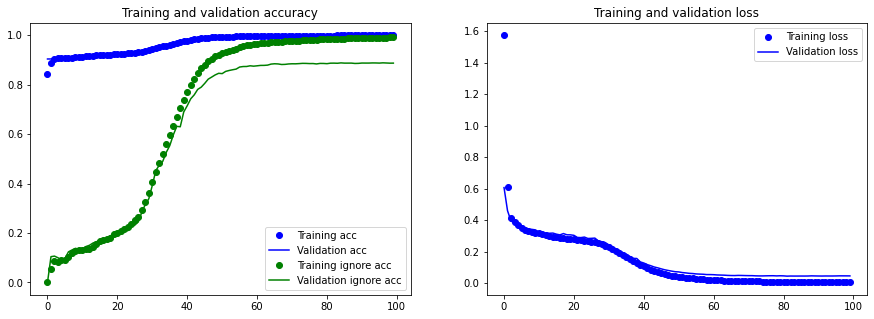

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
ignore_acc = history.history['ignore_accuracy']
val_ignore_acc = history.history['val_ignore_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, ignore_acc, 'go', label='Training ignore acc')
plt.plot(epochs, val_ignore_acc, 'g', label='Validation ignore acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
